# Glasgow GSP Demand Data Detrending
Graeme Hawker, University of Strathclyde, 9th August 2019

In [90]:
import zipfile
import pandas as pd
import datetime as dt
import numpy as np
import pytz
from scipy.signal import welch
from scipy.optimize import curve_fit
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import cm
from matplotlib.dates import DateFormatter
from matplotlib import rcParams
%matplotlib inline
plt.rcParams['figure.figsize'] = [11.60,16.53]
plt.rcParams['figure.dpi'] = 150 

In [3]:
def sp_to_dt(SD, SP, period_start=True):
    """
    Converts a settlement date and settlement period to a timezone-aware
    datetime object
    Parameters
    ----------
    SD : datetime.date object
        the settlement date
    SP : int
        the settlement period (in range 1 to 50)
    period_start : bool
        whether the desired datetime object should relate to the start (True)
        or end (False) of the settlement period
    Returns
    -------
    datetime : datetime.datetime
        a timezone-aware datetime object
    """
    #check date object passed - not datetime
    if not isinstance(SD, dt.date):
        raise ValueError('Expected Settlement Date parameter not of type datetime.date')

    #minimum SP value check
    if SP < 1:
        raise ValueError('SP value of %d less than minimum value of 1' % SP)

    #maximum SP value check, taking into account transition days
    transition_days = [dt.date(x.year, x.month, x.day)
                       for x in pytz.timezone('Europe/London')._utc_transition_times]
    if SD in transition_days[::2]: #clocks go forward
        if SP > 46:
            raise ValueError('SP value of %d exceeds maximum value of 46 \
                             for forward clock change date' % SP)
    elif SD in transition_days[1::2]: #clocks go back
        if SP > 50:
            raise ValueError('SP value of %d exceeds maximum value of 50 \
                             for backward clock change date' % SP)
    elif SP > 48:
        raise ValueError('SP value of {} exceeds maximum value of 48 for \
                         non-clock change date {}'.format(SP, SD))

    datetime = dt.datetime(SD.year, SD.month, SD.day, tzinfo=pytz.utc)
    datetime += dt.timedelta(minutes=(SP-1)*30)
    if not period_start:
        datetime += dt.timedelta(minutes=30)

    # DST shift should only be applied on days after transition day
    # (as does not impact calculation until SP resets to 1)
    if SD in transition_days[::2]:
        pass
    elif SD in transition_days[1::2] and SP > 2:
        datetime -= dt.timedelta(hours=1)
    else:
        datetime -= datetime.astimezone(pytz.timezone('Europe/London')).dst()
    return datetime

In [37]:
#detrending functions

#function to be fitted to annual data - 3 sinusoidal terms with base angular frequency of 1/2 hour and two harmonics
def annualTrend(t,a0,a1,a2,a3,c1,c2,c3):
    if type(t) is dt.datetime:
        t = (t-dt.datetime(t.year,1,1)).total_seconds()/3600  #convert datetime object into hours since start of year
    b1 = 2.0*np.pi/(24.0*365.0*2.0)
    b2 = 2.0*b1
    b3 = 3.0*b1
    return a0+a1*np.sin(b1*t+c1)+a2*np.sin(b2*t+c2)+a3*np.sin(b3*t+c3)
    
#function to be fitted to daily residuals - 2 sinusoidal terms with base angular frequency of 1/2 hour and single harmonic  
def diurnalTrend(t,a0,a1,a2,c1,c2):
    if type(t) is pd.Timestamp:
        t = t.hour
    b1 = 2.0*np.pi/(24.0*2.0)
    b2 = 2.0*b1
    return a0+a1*np.sin(b1*t+c1)+a2*np.sin(b2*t+c2)
    
#season definitions by month    
def getSeason(timestamp):
    if timestamp.month <=3:
        return 0
    elif timestamp.month <=6:
        return 1
    elif timestamp.month <=9:
        return 2
    return 3
    
#wrapper to allow diurnal value to be returned without separately calculating season    
def diurnalTrendWithSeason(t,coefficients):
    return diurnalTrend(t,*coefficients[getSeason(t)])
    
#wrapper to curve fitting function to return annual trend coefficients
def getAnnualCoefficients(timeseries):
    timeseries = timeseries.dropna()
    integerIndex=np.arange(len(timeseries))
    Apopt, Apcov = curve_fit(annualTrend, integerIndex, timeseries, p0=np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1]))
    return Apopt    
    
#wrapper to curve fitting function to return diurnal trend coefficients
def getDiurnalTrendCoefficients(timeseries):
    timeseries = timeseries.dropna()
    Dpopt, Dpcov = curve_fit(diurnalTrend, np.arange(24), timeseries, p0=np.array([0.1,0.1,0.1,0.1,0.1]))
    return Dpopt

In [5]:
#paths
GSP_data_path = '/home/graeme/Downloads/P114_gsp_data.zip'

In [6]:
#list all GSPs in a given GSP group area
GSP_area = 'N'
with zipfile.ZipFile(GSP_data_path) as z:
    with z.open('{}_gsp_data.csv'.format(GSP_area)) as f:
        raw_data = pd.read_csv(f)
        
raw_data['gsp_id'].unique()

array(['AYRR', 'BAIN', 'BROX', 'CAFA', 'CATY', 'CHAS', 'COAT', 'COCK',
       'CURR', 'DEVM', 'DEVO', 'DRCR', 'DRUM', 'DUMF', 'DUNB', 'ELDE',
       'GIFF', 'GLLE', 'GLLU', 'GLNI', 'GLRO', 'HAGR', 'HAWI', 'HELE',
       'HUER', 'KEOO', 'KILB', 'KILS', 'KILW', 'LEVE', 'PAIS', 'PART',
       'POOB', 'SACO', 'SANX', 'SHRU', 'SPAV', 'STIR', 'STLE', 'TONG',
       'WFIE', 'WGEO', 'WHHO', 'WISH', 'BAGA', 'BERW', 'BONN', 'BRAP',
       'CHAP', 'CLYM', 'COYL', 'CROO', 'CUMB', 'CUPA', 'DEWP', 'DUNF',
       'EAST', 'ECCL', 'EERH', 'EKIL', 'EKIS', 'ERSK', 'GALA', 'GORG',
       'GOVA', 'GRMO', 'INKE', 'JOHN', 'KAIM', 'KIER', 'KILT', 'LING',
       'LINM', 'MAYB', 'NEAR', 'NETS', 'PORD', 'RAVE', 'REDH', 'SIGH',
       'STHA', 'TELR', 'TOWH', 'ABNELVF', 'DFIN', 'KILN', 'DRYM', 'DALM3',
       'FINN'], dtype=object)

In [101]:
#GSPs and date range to select
#GSPs = ['A_ELST_1', 'P_MYBS_P', 'L_INDQ1', 'L_LAND1', 'L_ABHA1', 'L_EXET1'] # variety from around GB
GSPs = ['N_FINN', 'N_GOVA', 'N_PART', 'N_SANX', 'N_WGEO', 'N_CHAS', 'N_PORD', 'N_BRAP'] # Glasgow GSPs
start_date, end_date = dt.date(2009,1,1), dt.date(2019,1,1)

#set up blank dataframe
rawTimeSeries = pd.DataFrame(columns=['timestamp']+GSPs)
rawTimeSeries['timestamp'] = pd.DatetimeIndex(start=start_date,end=end_date,freq='30T')
rawTimeSeries.set_index('timestamp', inplace=True)

#fetch data for each GSP and overwrite values in dataframe
for GSP in GSPs:
    print(GSP)
    with zipfile.ZipFile(GSP_data_path) as z:
        with z.open('{}_gsp_data.csv'.format(GSP.split('_')[0])) as f:
            raw_data = pd.read_csv(f)
            gsp_data = raw_data[raw_data.gsp_id=='_'.join(GSP.split('_')[1:])][['settlement_date', 'settlement_period', 'meter_volume']]
            gsp_data['timestamp'] = gsp_data.apply(lambda row: sp_to_dt(dt.date(int(str(row['settlement_date'])[:4]),
                                                                                    int(str(row['settlement_date'])[4:6]),
                                                                                    int(str(row['settlement_date'])[6:8])),
                                                                        row['settlement_period'], 
                                                                        period_start=True), axis=1)
            #gsp_data = gsp_data[['timestamp', 'meter_volume']].set_index('timestamp').sort_index()
            rawTimeSeries.update(gsp_data[['timestamp', 'meter_volume']].set_index('timestamp').sort_index().rename(columns={'meter_volume':GSP}).tz_convert(None))
rawTimeSeries = rawTimeSeries.convert_objects(convert_numeric=True)
rawTimeSeries = rawTimeSeries*2 # convert MWh/30mins to MW
rawTimeSeries

/home/graeme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


N_FINN
N_GOVA
N_PART
N_SANX
N_WGEO
N_CHAS
N_PORD
N_BRAP


/home/graeme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,N_FINN,N_GOVA,N_PART,N_SANX,N_WGEO,N_CHAS,N_PORD,N_BRAP
timestamp,,,,,,,,
2009-01-01 00:00:00,NaN,28.060,36.190,23.53,39.91,51.040,56.050,22.050
2009-01-01 00:30:00,NaN,27.420,35.520,23.61,39.94,51.550,57.070,21.520
2009-01-01 01:00:00,NaN,27.080,34.790,24.05,40.14,52.360,58.260,20.880
2009-01-01 01:30:00,NaN,26.590,33.790,23.39,39.71,51.320,57.360,20.710
2009-01-01 02:00:00,NaN,26.270,33.470,23.01,39.09,50.560,57.270,20.570
2009-01-01 02:30:00,NaN,25.830,33.140,22.34,38.63,50.020,56.260,20.460
2009-01-01 03:00:00,NaN,25.090,31.740,21.52,37.81,49.130,54.760,19.920
2009-01-01 03:30:00,NaN,24.240,30.450,21.49,37.30,48.220,52.890,19.270
2009-01-01 04:00:00,NaN,23.770,29.290,20.74,37.01,47.030,51.630,18.770


In [102]:
#perform fitting of annual trend function, store coefficients in dataframe
print("Fitting annual trends...")
annualCoeffsDF = rawTimeSeries.apply(lambda x: pd.Series(getAnnualCoefficients(x)))
annualCoeffsDF.index = ['a0','a1','a2','a3','c1','c2','c3']
annualCoeffsDF

Fitting annual trends...


,N_FINN,N_GOVA,N_PART,N_SANX,N_WGEO,N_CHAS,N_PORD,N_BRAP
a0,21.290804,25.700746,28.672342,21.966090,39.541171,48.885527,39.989739,23.389003
a1,-0.901300,-3.658699,-5.543470,4.267882,-3.470057,-5.819984,-8.337679,2.702158
a2,0.731460,0.546744,-0.223189,0.652356,-0.872435,0.448054,1.954120,0.137370
a3,0.553407,0.337502,0.291204,-0.543415,-0.601644,1.017629,0.460156,-0.433326
c1,4.837829,17.106987,10.674240,26.166454,17.336025,23.269979,23.078690,20.204659
c2,-7.576143,0.556885,0.686761,-2.320473,-35.222735,0.419951,-5.090096,-0.197803
c3,2.797825,-0.640081,-1.412661,0.984980,8.100609,-1.267945,4.137780,-5.138291


In [103]:
#create mirror of timeseries data with calculated annual components only
print("Generating annual components...")
annualComponentTimeSeries = pd.DataFrame(index=rawTimeSeries.index)
for column in annualCoeffsDF:
    columnData = pd.DataFrame([annualTrend(x,*annualCoeffsDF[column].values) 
                               for x in np.arange(len(rawTimeSeries.index))],
                              index=rawTimeSeries.index,
                              columns=['data'])
    annualComponentTimeSeries[column] = columnData.loc[:,['data']]
annualComponentTimeSeries.head()

Generating annual components...


,N_FINN,N_GOVA,N_PART,N_SANX,N_WGEO,N_CHAS,N_PORD,N_BRAP
timestamp,,,,,,,,
2009-01-01 00:00:00,21.668131,29.393003,33.502987,24.702800,41.883608,53.670570,48.802769,25.606937
2009-01-01 00:30:00,21.667674,29.393852,33.503540,24.702942,41.884188,53.671791,48.804405,25.607048
2009-01-01 01:00:00,21.667217,29.394700,33.504093,24.703083,41.884768,53.673012,48.806040,25.607160
2009-01-01 01:30:00,21.666760,29.395547,33.504646,24.703225,41.885348,53.674234,48.807674,25.607272
2009-01-01 02:00:00,21.666303,29.396394,33.505198,24.703367,41.885929,53.675456,48.809306,25.607384


In [104]:
#create mirror of timeseries data with residuals (subtract annual components from raw time series data) 
print("Generating annual residuals...")
annualResiduals = rawTimeSeries.subtract(annualComponentTimeSeries)
annualResiduals.head()

Generating annual residuals...


,N_FINN,N_GOVA,N_PART,N_SANX,N_WGEO,N_CHAS,N_PORD,N_BRAP
timestamp,,,,,,,,
2009-01-01 00:00:00,NaN,-1.333003,2.687013,-1.172800,-1.973608,-2.630570,7.247231,-3.556937
2009-01-01 00:30:00,NaN,-1.973852,2.016460,-1.092942,-1.944188,-2.121791,8.265595,-4.087048
2009-01-01 01:00:00,NaN,-2.314700,1.285907,-0.653083,-1.744768,-1.313012,9.453960,-4.727160
2009-01-01 01:30:00,NaN,-2.805547,0.285354,-1.313225,-2.175348,-2.354234,8.552326,-4.897272
2009-01-01 02:00:00,NaN,-3.126394,-0.035198,-1.693367,-2.795929,-3.115456,8.460694,-5.037384


In [105]:
#get hourly averages by season for annual residuals
print("Fitting diurnal trends...")
hourlySeasonalAverages = annualResiduals.groupby([getSeason,
                                                  annualResiduals.index.map(lambda t: t.hour)]).mean()
hourlySeasonalAverages.head()

Fitting diurnal trends...


N_FINN    N_GOVA    N_PART    N_SANX     N_WGEO     N_CHAS  \
  timestamp                                                                 
0 0         -4.779711 -3.393028 -2.980332 -2.357711  -9.575325 -10.211021   
  1         -5.450662 -4.546374 -5.419233 -3.198098 -10.846990 -11.911197   
  2         -6.207928 -5.720690 -7.587672 -4.656343 -12.303743 -14.255727   
  3         -6.499032 -6.447209 -8.903554 -5.229165 -13.071265 -15.339353   
  4         -6.412691 -6.679250 -9.517949 -5.680700 -13.299565 -15.834843   

                N_PORD    N_BRAP  
  timestamp                       
0 0          -5.696096 -5.691544  
  1          -6.878329 -6.703986  
  2          -9.570012 -7.360599  
  3         -11.085328 -7.775594  
  4         -11.877453 -7.680094

In [106]:
#perform fitting of diurnal trend function, store coefficients in array
diurnalCoeffs = []
diurnalCoeffsDF = pd.DataFrame(index=['a0','a1','a2','c1','c2'])
for column in hourlySeasonalAverages.columns.values.tolist():
    nodeDiurnalCoeffs = []
    for season in hourlySeasonalAverages.index.levels[0]:
        Dpopt, Dpcov = curve_fit(diurnalTrend,
                                 np.arange(24),
                                 hourlySeasonalAverages.loc[season,:][column].values,
                                 p0=np.array([0.1,0.1,0.1,0.1,0.1]))
        nodeDiurnalCoeffs.append(Dpopt)
    diurnalCoeffs.append(nodeDiurnalCoeffs)
    diurnalCoeffsDF[column] = Dpopt
diurnalCoeffsDF

,N_FINN,N_GOVA,N_PART,N_SANX,N_WGEO,N_CHAS,N_PORD,N_BRAP
a0,2.294911,4.783856,-0.182301,1.006169,10.158933,9.224882,5.605924,1.643193
a1,4.330148,7.581001,2.620431,-1.996425,16.275262,-14.714157,9.217450,3.016708
a2,-7.201167,-7.794995,-5.141787,-4.725992,-18.996604,-19.875099,11.721582,-7.518354
c1,-9.105343,-2.906385,-70.575309,-12.075282,-9.294330,-6.166386,-2.946101,-8.938033
c2,-23.691537,-4.845406,-36.810364,-36.688197,-11.140476,-162.030855,-1.913909,-11.267494


In [107]:
print("Generating diurnal components...")   
#create mirror of timeseries data with calculated diurnal components only
diurnalComponentTimeSeries = pd.DataFrame(index=rawTimeSeries.index)
for column,coefficients in zip(rawTimeSeries.columns.values.tolist(),
                               diurnalCoeffs):
    columnData = pd.DataFrame([diurnalTrendWithSeason(x,coefficients) for x in rawTimeSeries.index],
                              index=rawTimeSeries.index,
                              columns=['data'])
    diurnalComponentTimeSeries[column] = columnData.loc[:,['data']]
diurnalComponentTimeSeries.head()

Generating diurnal components...


,N_FINN,N_GOVA,N_PART,N_SANX,N_WGEO,N_CHAS,N_PORD,N_BRAP
timestamp,,,,,,,,
2009-01-01 00:00:00,-5.319188,-3.727441,-4.845302,-2.621238,-9.182945,-10.039269,-5.496904,-6.256993
2009-01-01 00:30:00,-5.319188,-3.727441,-4.845302,-2.621238,-9.182945,-10.039269,-5.496904,-6.256993
2009-01-01 01:00:00,-6.068187,-5.208686,-6.210256,-3.840589,-12.016917,-13.400706,-8.415134,-7.238015
2009-01-01 01:30:00,-6.068187,-5.208686,-6.210256,-3.840589,-12.016917,-13.400706,-8.415134,-7.238015
2009-01-01 02:00:00,-6.271980,-5.998989,-7.069182,-4.638835,-13.373911,-15.162639,-10.194760,-7.597764


In [108]:
print("Generating diurnal residuals...")
#create mirror of timeseries data with both annual and diurnal components removed    
detrendedTimeSeries = annualResiduals.subtract(diurnalComponentTimeSeries)
detrendedTimeSeries.head()

Generating diurnal residuals...


,N_FINN,N_GOVA,N_PART,N_SANX,N_WGEO,N_CHAS,N_PORD,N_BRAP
timestamp,,,,,,,,
2009-01-01 00:00:00,NaN,2.394437,7.532315,1.448437,7.209336,7.408699,12.744135,2.700056
2009-01-01 00:30:00,NaN,1.753589,6.861761,1.528296,7.238757,7.917478,13.762498,2.169945
2009-01-01 01:00:00,NaN,2.893987,7.496163,3.187506,10.272149,12.087694,17.869094,2.510855
2009-01-01 01:30:00,NaN,2.403139,6.495610,2.527364,9.841569,11.046472,16.967460,2.340743
2009-01-01 02:00:00,NaN,2.872595,7.033983,2.945468,10.577983,12.047184,18.655453,2.560381


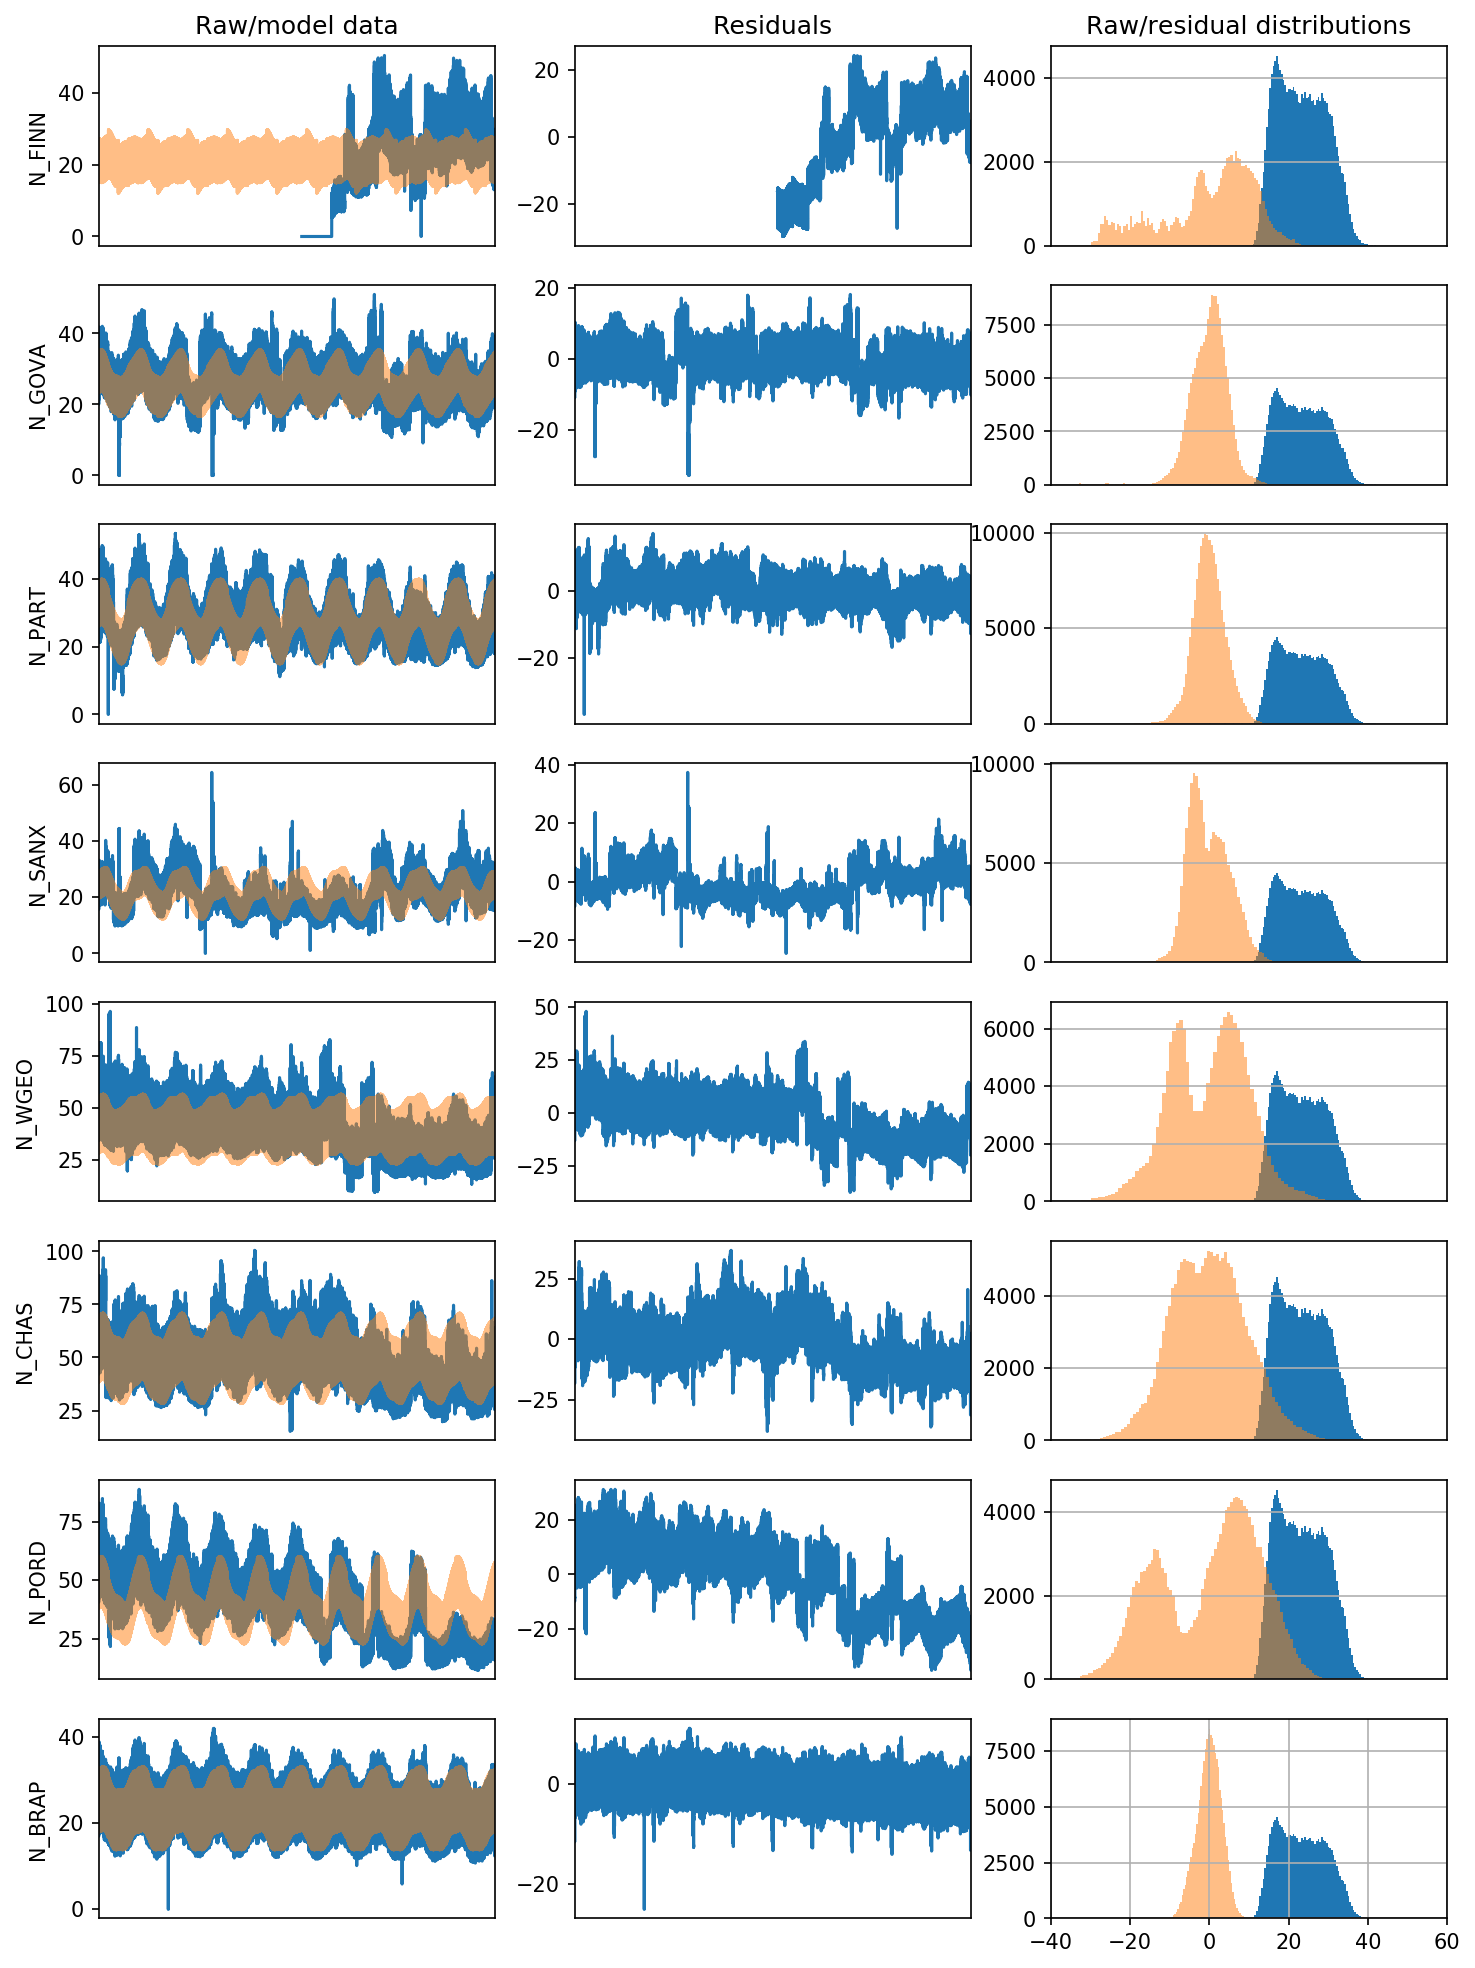

In [109]:
#generate plots for all GSPs
fig, axes = plt.subplots(nrows=len(GSPs), ncols=3)
#fig.autofmt_xdate()
#myFmt = DateFormatter("%y") 

for i in range(len(GSPs)):
    ax1 = rawTimeSeries[GSPs[i]].plot(ax=axes[i,0]) #raw data
    ax1.set_ylabel(GSPs[i])
    if i==0:
        ax1.title.set_text('Raw/model data')
    ax1.xaxis.set_visible(False)
    (annualComponentTimeSeries[GSPs[i]]+diurnalComponentTimeSeries[GSPs[i]]).plot(ax=ax1, alpha=0.5) #annual plus diurnal components
    ax2 = detrendedTimeSeries[GSPs[i]].plot(ax=axes[i,1])
    if i==0:
        ax2.title.set_text('Residuals')
    ax2.xaxis.set_visible(False)
    ax3 = rawTimeSeries[GSP].hist(bins=100, ax=axes[i,2])
    ax3 = detrendedTimeSeries[GSPs[i]].hist(bins=100, ax=ax3, alpha=0.5)
    ax3.set_xlim([-40, 60])
    if i==0:
        ax3.title.set_text('Raw/residual distributions')
    if i<len(GSPs)-1:
        ax3.xaxis.set_visible(False)
fig.savefig('glasgow_GSP_trends.pdf', dpi=fig.dpi)
    

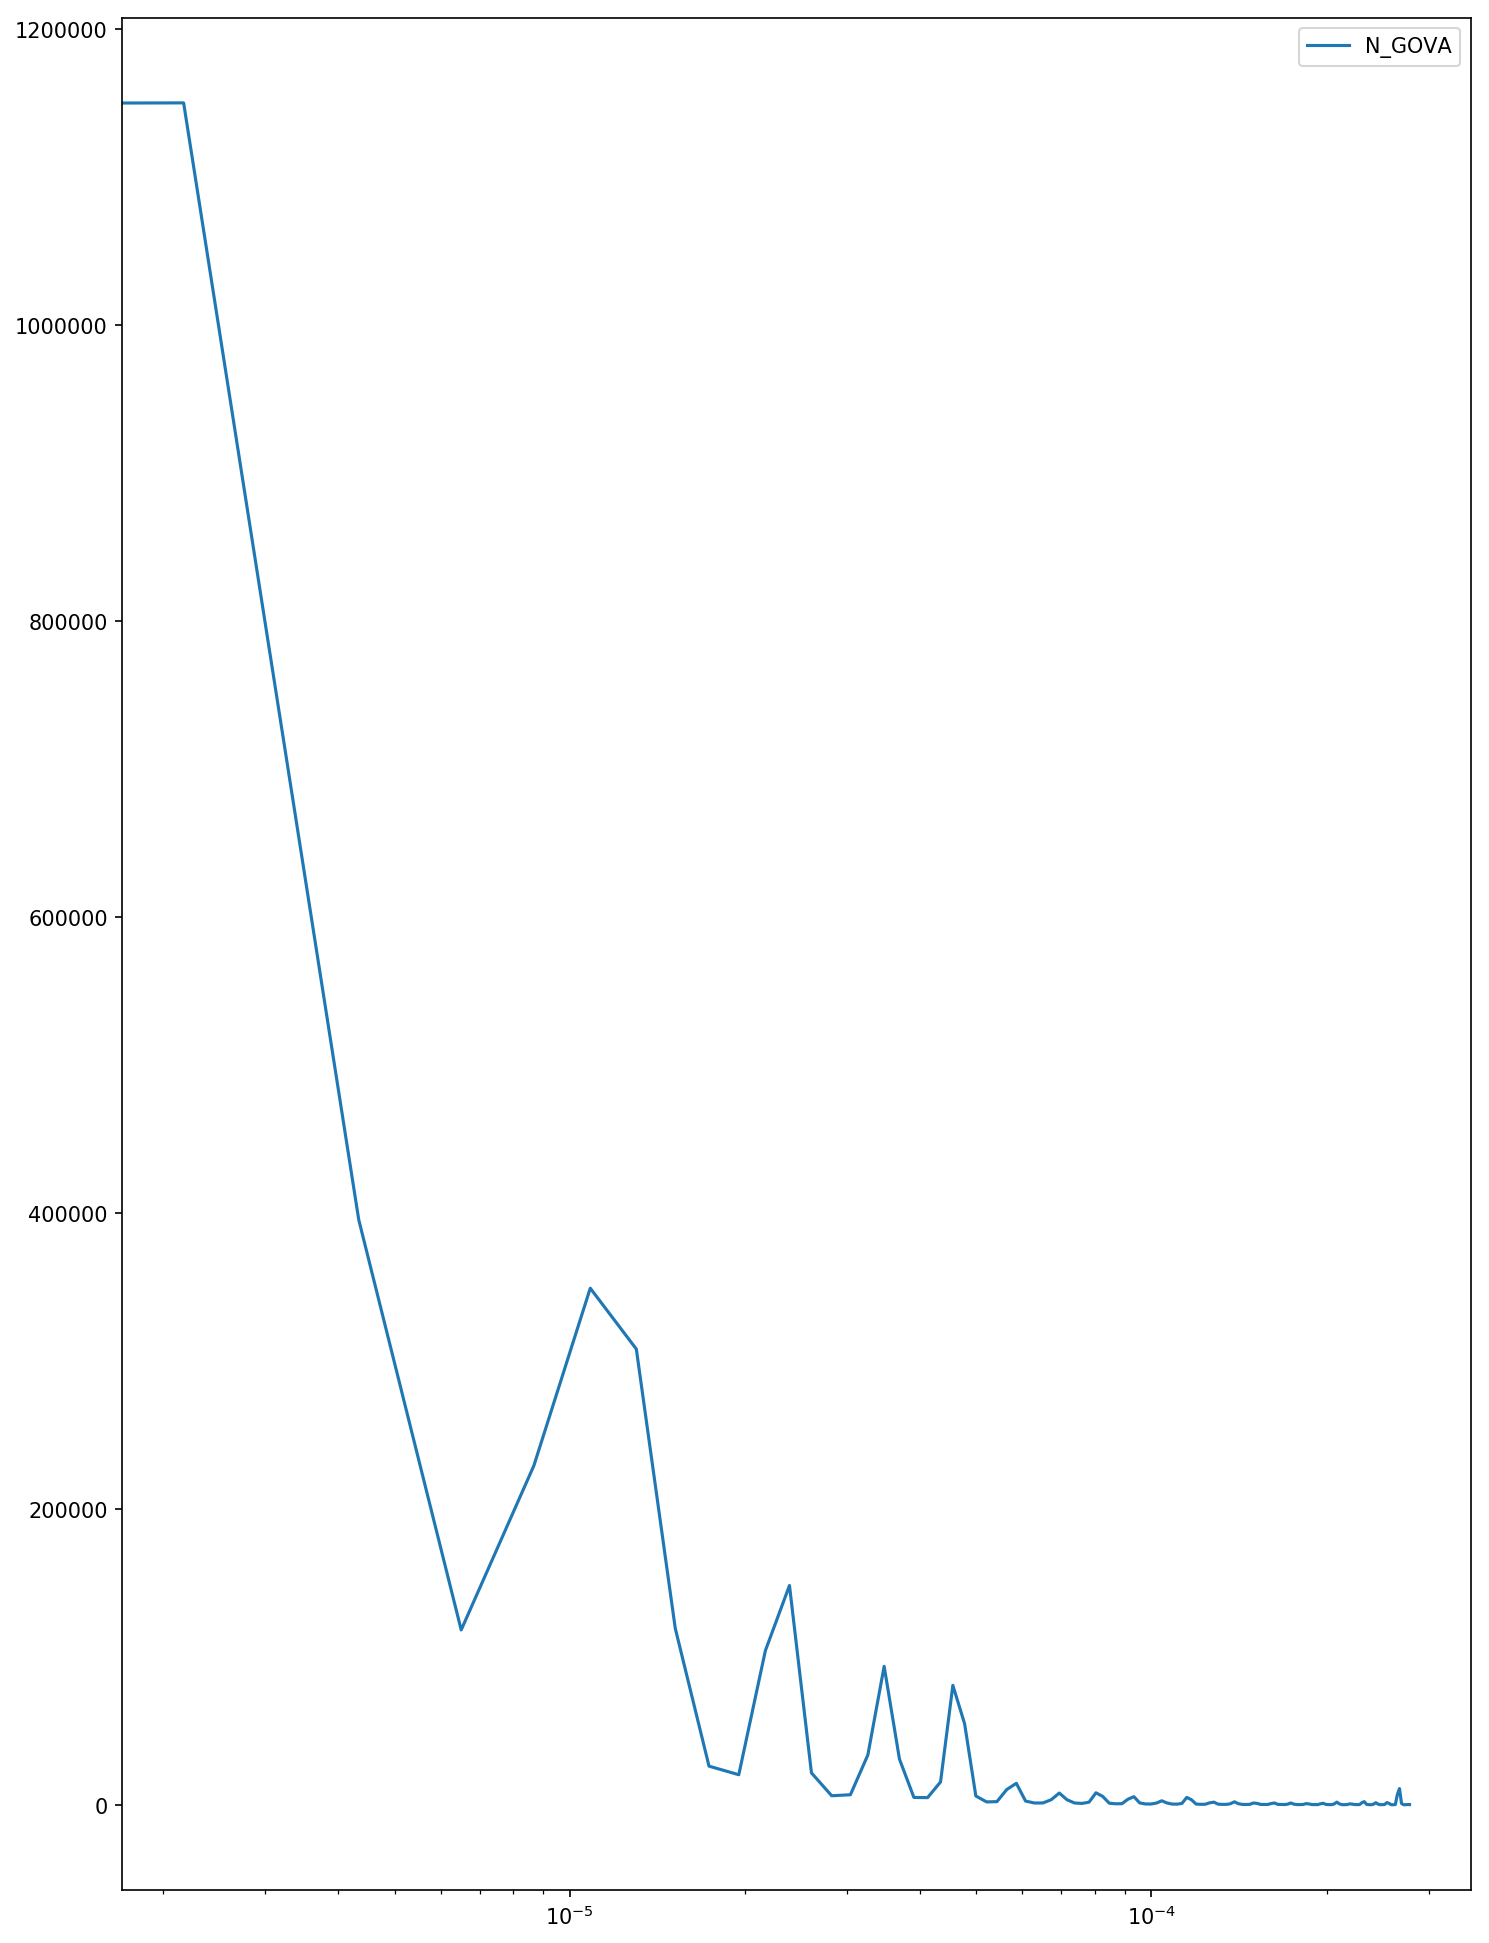

In [110]:
#look at power spectrum of residuals
GSP = 'N_GOVA'
f, psd = welch(detrendedTimeSeries[GSP].values,
               fs = 1/1800.0,
               window = 'hanning',
               detrend = 'constant')
plt.semilogx(f, psd, label=GSP)
plt.legend()

In [111]:
#test if detrended data is normal - if p-value is less than critical value (e.g. 0.05)
k2, p = stats.normaltest(detrendedTimeSeries[GSP])
p

0.0

In [112]:
#test if detrended data is stationary 
#https://machinelearningmastery.com/time-series-data-stationary-python/
#if ADF statistic is less than critical value then series has no unit root 
#i.e. can be considered stationary
result = adfuller(detrendedTimeSeries[GSP])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -25.439792
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
